<center>
    <h1> Study of the Covid-19 Vaccine Acceptance</h1>
    <h4> BDA Fall 2020 - Final Project </h4>
    <hr>
    <br><br>
    <h3>Rafel Palliser & Albert Rial</h3>
    <br><br>
</center>

## 1. Problem description

The goal of this study is to analyze the acceptance of the Covid-19 Vaccine by examinating tweets referring to it. We truly think this is an important study because Covid-19 has drastically changed our lives, and its vaccine could change them again.

The followed pipeline starts by gathering the data throughout the Twitter API and storing it into a MongoDB. Once done, we perform a first data exploration to study the different fields contained in a tweet, and if there are missing values in the fields we need for our analysis. Afterwards, the data is processed and cleaned in order to be completely prepared for the study of the vaccine acceptance.

ALGO MAS?!?

Introducció:
- Storytelling
- (Done) Com fer la query? Quina? (volíem dades al llarg de molt temps, no d'un instant concret)
- (Done) covid té hashtag, vacuna no --> triar idiomes --> query #covid 24h ......

Data Exploration:
- Estudi de fields
- Quants són rt, originals, ..?
- Estudi de missing values i com estan codificats dels que ens afecten (text, geo)
- Explicar GEO!!!
- Distribució idiomes
- Llista / Mapa d'on estan els tweets
- Evolució del nb de tweets al llarg del temps (histograma..) (incloure notícies)
- Llista de top hashtags
- Llista top words (exclude stopwords,...)?

Estudi. Study on the acceptance of covid-19 vaccine:
- Mapa / Dist d'on es parla més de cada vacuna (mirar la distribució de la vacuna que es parla més segons el país)
- Evolució del sentiment al llarg del temps (relació amb notícies)
- Evolució del sentiment al llarg del temps de cada vacuna
- Sentiment segons pais. Mapa global de pro-vaccine i anti-vaccine
- Sentiment segons pais i vacuna?

Hagués estat bé tenir edat/sexe per fer estudi sociologic però no el tenim.

## 2. Data gathering and storage

Data gathering is one of the most important parts of a data project or analysis, although it may not seem so. Sometimes the researcher cannot control this part because others gathered the data, and have to face other more complicated problems to process it and extract valuable information. In this project, we have the opportunity to design the data gathering process, and that's why we have spend much time on it.

The constraints on our data gathering process come from the theme of this project, Covid-19 Vaccine Acceptance, and the source we have decided to use, Twitter. Knowing that one of the key interaction factors of this social network are the use of hashtags, we noticed the fact that the Covid-19 Vaccine has not a hashtag associated to it, or at least not a global one in a similar way that Covid-19 has #Covid, #Covid19 or #Covid-19.

Also, the word vaccine is written in different ways depending on the language, so in order to not introduce a large bias on languages due to our query, we made a preliminar study of the most used languages in tweets talking about Covid-19. Trying to be as fair as possible, we collected tweets for exactly 24h (to not discriminate any time zone) containing one of the mentioned hashtags associated with Covid-19. We are aware that countries using a non-latin alphabet may refer to the virus in a different way, but we don't aim to obtain tweets in those languages as we won't be able to process the tweet text in our analysis. Taking this into account, we obtained the following results:

In [14]:
import pymongo
from src.keys import MONGODB_KEY
from bson.son import SON

client = pymongo.MongoClient('fpsds.synology.me', 27017, username='mongoadmin', password=MONGODB_KEY)
db = client['tweets']
tweets = db['covid_hashtags_24h']

<a id='lang_study'></a>

In [2]:
pipeline = [
    {'$group': {'_id': '$lang', 'count': {'$sum': 1}}},
    {"$sort": SON([("count", pymongo.DESCENDING)])},
    {'$limit': 10}
]
tot = tweets.count_documents({})
res = tweets.aggregate(pipeline)
acc = 0
langs = []
counts = []
print('Lang         %       Acc %')
for lang in res:
    langs.append(lang['_id'])
    counts.append(lang['count'])
    acc += lang['count']
    print('{:4s}    {:5.2f}%      {:5.2f}%'.format(lang['_id'], 100*lang['count']/tot, 100*acc/tot))

Lang         %       Acc %
en      61.58%      61.58%
es      17.08%      78.66%
fr       5.11%      83.77%
it       2.87%      86.63%
und      2.26%      88.90%
de       1.98%      90.88%
in       1.42%      92.30%
hi       1.22%      93.52%
ja       0.95%      94.47%
pt       0.93%      95.41%


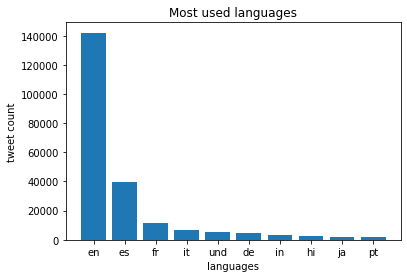

In [3]:
from src.plots import barplot
barplot(langs, counts, 'Most used languages', 'languages', 'tweet count')

Note that more than 60% of tweets are written in English, and another 17% in Spanish. The following most used language is French, which appears in 5% of the tweets, and the subsequent languages are only used in less than 3% of tweets. Looking at the histogram, it seems that the most logical choice would be to only look for tweets written in English. However, as these only cover the 60% of the gathered ones, we decided to also look after the Spanish ones, thus increasing our coverage to almost 80%.

Note that this is an approximation, assuming the tweets talking about the Covid-19 vaccine follow the same language distribution that the ones talking about Covid-19 generally.

### The actual data gathering process

The [Twitter API](https://developer.twitter.com/en) provides two main ways of gathering tweets. On one side we have the streaming option, which gets the tweets matching a certain query in real time. On the other, we have the option of dowloading indexed tweets from their database, from which one can download data from the 7-10 prior days with a free developer account.

After testing both options, we decided to go for the second one, as we could make queries every 7 days and obtain the tweets for the whole period without having to leave a computer running a script 24/7, much more time. Also, we predicted (now confirmed) that during December the vaccine topic would become more and more trendy, so we wanted to download tweets for a long period of time.

[src/collect_tweets.py](src/collect_tweets.py) is the script we have been using to download tweets and insert them in a database. We decided to not include the code in this notebook but leave it in a separate file because we run it asynchronously. In the file, one can see we have used [Tweepy](https://www.tweepy.org/) (a python library wrapping the Twitter API) and the actual parameters we have used to gather tweets. Apart from 'since', 'until' and 'max_id', which serve to control the period of time from we desire to download tweets; there is 'lang', which we set to 'None' (working as 'any') as the API does not accept a list of languages; and the most important one, the query itself: **'#covid OR #covid19 vaccine OR vacuna'**.

In the [documentation](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/guides/standard-operators) it can be easily seen that the 'OR' operator works as a logical OR betweet the two contiguous terms, and a simple whitespace works as an AND. Therefore, we are looking for tweets that contain (#covid or #covid19) and (vaccine or vacuna). The first part is to ensure the resulting tweets refer to the Covid-19 vaccine (note that #covid also matches #covid-19, so we are covering all the three most-used global hashtags for Covid-19). The second part is to ensure that the tweets specifically refer to the vaccine, and we include the word in English and Spanish as we decided in the previous language study because there is not a unified term to refer to the vaccine globaly. Note that we search for the word and not the hashtag, because although local hashtags #vaccine or #vacuna exists, few people use them. Also note that the way the Twitter search work, our query 'vaccine' also matches a possible hashtag '#vaccine', so we are not losing these results.

We have been running this script from November, 29 to XXXX and collected a total amount of XXXX tweets, which have been stored into a MongoDB database.

### Storage

Relational databases are a efficient solution for storage, but require strictly structured data, which does not directly match with tweets, which come in a json format and with several different fields depending on the type of tweet. For this reason, we have decided to use a NoSQL database. Specificaly we have chosen [MongoDB](https://www.mongodb.com/es), which is document oriented and matches the data type perfectly (json-like objects). The fact that we already know its language and it has a Python library ([PyMongo](https://pypi.org/project/pymongo/)) ready to use also played a role in our decision.

For this project, we set up a MongoDB server using [Docker](https://www.docker.com/), and left it running in a machine which is visible in the public network, so we are able to work from home with an online, up-to-date and synchronized database, which is always available.

## 3. Data Description

<a id='first_look'></a>
### 3.1. First look at our data

In this section we are going to present our data, explain the different fields it contains and the ones that will be important for our future analysis.

In [15]:
# Get the collection that contains all the tweets for our query
tweets = db['#covid_vaccine']

In [16]:
# Check the number of tweets in the database
n_tweets = tweets.count_documents({})
print('The total amount of tweets in the database is {}'.format(n_tweets))

The total amount of tweets in the database is 872828


In [17]:
# Check the size of the collection (note that this is approximate and includes data and indexes)
print('Collection size = {:.2f}GB'.format(db.command("collstats", "#covid_vaccine")['size']/1e9))

Collection size = 5.31GB


Each collected tweet document has many fields, and printing a complete one would take much space. For this reason, let's take a look to all the possible primary fields (not nested ones) a tweet can have:

In [18]:
%%time

key_set = set()
for tweet in tweets.find({}):
    tweet_keys = tweet.keys()
    key_set = key_set.union(tweet_keys)
print(sorted(list(key_set)))

KeyboardInterrupt: 

2 minuts if localhost

Note how retrieving all documents to perform computations is a really bad idea. In fact, we are actually moving approximately 5GB through the network without taking advantage of the power of databases, which are optimized to perform these kind of operations. For this reason, we are going to do the same in the DB side, by applying a MapReduce model:

In [19]:
%%time

# Take advantage of MapReduce, which is executed on the DB side
# Map function: Emit each key. We assign a value 'null' because we are only interested in the keys
# Shuffle: We will have a list of nulls for each different key
# Reduce: Don't look at the list 's', just return 'null' as we don't want any value, only the different keys
# Output: Store the information in a new collection
tweet_keys = tweets.map_reduce("""function() {for (var key in this) {emit(key, null);}}""", 
                  """function(key, s) {return null;}""",
                  "#covid_vaccine_keys")
keys = tweet_keys.find({},{'value': 0})
print([e['_id'] for e in keys])

KeyboardInterrupt: 

We obtain the same exact result while working 60 times faster! The meaning of all these fields is explained in the [Twitter API website](https://developer.twitter.com/en/docs/twitter-api/premium/data-dictionary/object-model/tweet), but we are going to review the ones that are interesting for our work:
- `_id` is the MongoDB unique id, which we manually set to be the tweet `id`, which is also unique and increases chronologically. It is encoded as an int64 and can also be found string formatted at `id_str`.
- `coordinates` contains the longitude and latitude from where the tweet was sent. `coordinates.coordinates` is a 2-dimensional array. Null if geolocalization is deactivated.
- `created_at` is a string containing the UCT timestamp of the creation of the tweet. Example: "Wed Oct 10 20:19:24 +0000 2018"
- `display_text_range` is an array containing the offsets of the characters that form the real text message. Note that when you reply to a tweet, your own tweet starts with the user mention `@user`, which is not part of your reply text.
- `entities` is an object-like attribute that contains, among others, the detected hashtags `#hashtag` and user mentions `@user` along with their character offsets.
- `full_text` is the most important field, containing the actual text of the tweet.
- `geo` is a deprecated field, now substituted by `coordinates`. Null if geolocalization is deactivated.
- `in_reply_to` family of attributes indicate if a tweet is actually a reply of another one, its id and its author. Null for non-reply tweets.
- `lang` indicates the language of the tweet, detected in a best-effort manner.
- `place` is an object-like field which includes information about the place from which a tweet has been sent (not only coordinates, but also country and sometimes city or even neighbourhood). Null if geolocalization is deactivated.
- `quoted_status` is an attribute only present if the tweet contains a quote to another tweet. The value of this attribute, if present, is another whole tweet object.
- `retweeted_status` is a field which is only present if the tweet is actually a retweet of another original tweet, contained in the attribute.
- `truncated` is a compatibility flag which indicates if a tweet text is truncated to 140 characters. It will be false in all our documents as we enabled 'extended_mode' in our query (see [src/collect_tweets.py](src/collect_tweets.py))
- `user` is a whole object with lots of different fields regarding the author of the tweet. Specifically, `user.location` is interesting because it shows the location the user has set to be visible in its profile. Note that this is a free field, and the user can write anything on it.

Let's see a tweet projecting the attributes we really are interested in:

In [47]:
tweets.find_one({},{'_id':1, 'coordinates':1, 'created_at':1, 'display_text_range':1, 
                    'entities.hashtags':1, 'full_text':1, 'in_reply_to_status_id':1, 'lang':1, 
                    'place':1, 'quoted_status':1, 'retweeted_status':1, 'user.location':1})

{'_id': 1336317355832602627,
 'created_at': 'Tue Dec 08 14:30:59 +0000 2020',
 'full_text': 'Covid-19: Big pharma to the rescue | Our winter 2020 #coverstory looks at what IR is like under the coronavirus spotlight. We hear from @AstraZeneca, CureVac, @Sentieo and @MorganStanley on the impact for the sector | IR Magazine https://t.co/nnpwucYkSi #irchat #covid19 #vaccine',
 'display_text_range': [0, 279],
 'entities': {'hashtags': [{'text': 'coverstory', 'indices': [53, 64]},
   {'text': 'irchat', 'indices': [254, 261]},
   {'text': 'covid19', 'indices': [262, 270]},
   {'text': 'vaccine', 'indices': [271, 279]}]},
 'in_reply_to_status_id': None,
 'user': {'location': 'Global'},
 'coordinates': None,
 'place': None,
 'lang': 'en'}

From the result, apart from the directly interpretable attributes, we can see that this user has not enabled geolocalization because both `place` and `coordinates` are None. Also, we can see that the location she uses in her profile `user.location` is actually not providing any information about that. Additionally, we can state this is an original tweet, as it is not a retweet nor a quote (as those attributes do not appear).

### 3.2. Study of the different fields

In this section we are going to study the fields that are important for our analysis in more depth.

#### Tweet "type"

Recognizing the tweet type is important for several reasons.

The first and most important one is to understand the possible interactions in Twitter, and what they imply. A retweet shows agreement with what the original tweet said. However, when quoting, the author can agree or not with the quoted tweet. 

Second, the key information is stored in different fields depending on the tweet type, so identifying it is key for the analysis.

Note that replies (comments to an "original" tweet) will be treated as original tweets themselves, because they don't provide information of the tweet they replied, only the tweet id, which is usually not found in the database.

In [21]:
# Check if replied tweets are in the database
replies = tweets.find({'in_reply_to_status_id': {'$ne': None}}, {'in_reply_to_status_id':1, '_id':0})
list_of_replied_ids = [e['in_reply_to_status_id'] for e in replies]

count = tweets.count_documents({'_id': {'$in': list_of_replied_ids}})
print('Only {} replied tweets are contained in the datbase. This is a {:.2f}% of the number of replies.'.format(count, 100*count/len(list_of_replied_ids)))

Only 2609 replied tweets are contained in the datbase. This is a 12.10% of the number of replies.


As seen in [Section 3.1](#first_look), we can recognize if a tweet object is a retweet by the appearence of the `retweeted_status` attribute. Same with `quoted_status` for quote tweets.

In [22]:
n_retweets = tweets.count_documents({'retweeted_status': {'$exists': True}})
n_quotes = tweets.count_documents({'quoted_status': {'$exists': True}})
n_originals = n_tweets - n_retweets - n_quotes

print('There are {} original tweets, representing a {:.2f}% of the total amount.'.format(n_originals, 100*n_originals/n_tweets))
print('There are {} retweets, representing a {:.2f}% of the total amount.'.format(n_retweets, 100*n_retweets/n_tweets))
print('There are {} quotes, representing a {:.2f}% of the total amount.'.format(n_quotes, 100*n_quotes/n_tweets))

There are 176775 original tweets, representing a 20.25% of the total amount.
There are 674140 retweets, representing a 77.24% of the total amount.
There are 21913 quotes, representing a 2.51% of the total amount.


Note that the vast majority of tweet objects correspond to retweets, then we have a 20% original tweets, and a small amount of quotes.

Now let's see how the tweet text is shown in each of these tweet types. Starting with original ones:

In [24]:
original = tweets.find_one({'retweeted_status': {'$exists': False}, 'quoted_status': {'$exists': False}})
print(original['full_text'])

Covid-19: Big pharma to the rescue | Our winter 2020 #coverstory looks at what IR is like under the coronavirus spotlight. We hear from @AstraZeneca, CureVac, @Sentieo and @MorganStanley on the impact for the sector | IR Magazine https://t.co/nnpwucYkSi #irchat #covid19 #vaccine


Nothing to say about this, `full_text` seems to show the text of the original tweet. Let's move to retweets:

In [26]:
retweet = tweets.find_one({'retweeted_status': {'$exists': True}})
print(retweet['full_text'])

RT @BungerKCBSRadio: Surge. Vaccine. Lockdown.  So many hot #COVID19 topics right now. I'll have @Bob_Wachter with me for #AskAnExpert at 9…


Two things to note here. To begin with, first characters 'RT' indicate it is a retweet. Next ones indicate from whom the retweeted tweet was. Therefore, this characters do not really form part of the text. Second, if we now take a look to `display_text_range`, we can see that the tweet has exactly 140 characters, which is a strange coincidence taking into account that we just saw the text ends in '...':

In [28]:
print(retweet['display_text_range'])

[0, 140]


Looking at the text of the retweeted status:

In [30]:
print(retweet['retweeted_status']['full_text'])

Surge. Vaccine. Lockdown.  So many hot #COVID19 topics right now. I'll have @Bob_Wachter with me for #AskAnExpert at 9:20 AM PST. Send questions to: askus@kcbsradio.com then listen at 9:20 AM on @KCBSRadio @Radiodotcom app &amp; smart speaker (say "Play KCBS Radio") https://t.co/uQsiOzNDpv


Note that looking at the original text we solve both problems. First, we don't have the annoying "RT @user", which we had to remove to process the text; and second, we obtain a text which is no longer cut. Therefore, when we process retweets we will use the `full_text` field of the retweeted status, not the retweet itself. Now let's analyze quotes:

In [32]:
quote = tweets.find_one({'quoted_status': {'$exists': True}})
print(quote['full_text'])
print(quote['display_text_range'])

Dr. #Fauci says that the New York City #firefighters resistance to the vaccine is based on #misinformation just like other people in society who are fearful of the vaccine. #COVID19 https://t.co/Vys5fiNwjV
[0, 181]


It seems to be all right here. Taking into account that the text will make reference to a quoted tweet, when processing quotes we will also take into account the actual quoted text:

In [33]:
print(quote['quoted_status']['full_text'])

Over half of New York City firefighters would refuse COVID-19 vaccine, survey finds. https://t.co/2Dlqb3gDIW


#### Tweet Language

Let's see the distribution of languages in our tweets. We would expect mainly English and Spanish as we have specificaly used the word 'vaccine' in these languages. However, as we could not set the attribute 'lang' in the Twitter API query, we could have some tweets in other languages that used the same words.

In [20]:
# Let's print the top 10 most used languages in tweets referring to Covid-19 vaccine
pipeline = [
    {'$group': {'_id': '$lang', 'count': {'$sum': 1}}},
    {"$sort": SON([("count", pymongo.DESCENDING)])},
    {'$limit': 10}
]
res = tweets.aggregate(pipeline)
acc = 0
langs = []
counts = []
print('Lang         %       Acc %')
for lang in res:
    langs.append(lang['_id'])
    counts.append(lang['count'])
    acc += lang['count']
    print('{:4s}    {:5.2f}%      {:5.2f}%'.format(lang['_id'], 100*lang['count']/n_tweets, 100*acc/n_tweets))

Lang         %       Acc %
en      73.48%      73.48%
es      21.87%      95.35%
fr       1.31%      96.66%
und      0.85%      97.51%
hi       0.56%      98.07%
ca       0.41%      98.48%
tl       0.17%      98.65%
in       0.17%      98.82%
it       0.15%      98.97%
pt       0.13%      99.10%


This result is completely expected. On one side, there are more than triple the tweets in English than in Spanish, following a quite similar distribution than the one seen in the [previous language study](#lang_study). On the other side, there are some tweets (less than 5%) from other languages, in which they might have included the English word 'vaccine', for example.

As this language attribute is provided in a best-effor manner, in further sections we will analyze it.

#### Geolocalization

Being able to locate from where tweets were sent is an important part for the analysis we aim to perform. For this reason, let's see which information tweets contain.

Let's start by analyzing the field `coordinates`, and `geo` which is its deprecated field:

In [34]:
have_coordinates = tweets.count_documents({'coordinates': {'$ne': None}})
have_geo = tweets.count_documents({'geo': {'$ne': None}})
print('There are {} tweets with coordinates, which corresponds to a {:.2f}%'.format(have_coordinates, 100*have_coordinates/n_tweets))
print('There are {} tweets with geo, which corresponds to a {:.2f}%'.format(have_geo, 100*have_geo/n_tweets))

There are 142 tweets with coordinates, which corresponds to a 0.02%
There are 142 tweets with geo, which corresponds to a 0.02%


Only a tiny part of the data has coordinates associated. Let's check the fact that these 142 tweets are actually the same:

In [35]:
geo_coordinates = tweets.count_documents({'coordinates': {'$ne': None}, 'geo': {'$ne': None}})
print(geo_coordinates)

142


They are actually the same! Let's analyze the `place` field now:

In [36]:
have_place = tweets.count_documents({'place': {'$ne': None}})
print('There are {} tweets with place, which corresponds to a {:.2f}%'.format(have_place, 100*have_place/n_tweets))

There are 5827 tweets with place, which corresponds to a 0.67%


Slightly better, but not that much. Let's check if there is any overlap within tweets containing `place` and `coordinates`.

In [37]:
place_coordinates = tweets.count_documents({'place': {'$ne': None}, 'coordinates': {'$ne': None}})
print(place_coordinates)

142


All tweets with coordinates also have place. Therefore we have a total of 5827 tweets, a 0.67% of all, with geolocalization. This is obviously useless to perform a decent study. For this reason, let's check the field `user.location`, in which each user can write anything, hoping to find valuable information:

In [48]:
pipeline = [
    {'$group': {'_id': '$user.location', 'count': {'$sum': 1}}},
    {"$sort": SON([("count", pymongo.DESCENDING)])},
    {'$limit': 25}
]
res = tweets.aggregate(pipeline)

locations = []
counts = []
print('Count      Location')
for loc in res:
    locations.append(loc['_id'])
    counts.append(loc['count'])
    print('{:6d}     {}'.format(loc['count'], loc['_id']))
locations.append('others')
counts.append(n_tweets - sum(counts))

Count      Location
264872     
  9685     United States
  7606     México
  6368     Washington, DC
  5132     India
  4802     New York, NY
  4633     Canada
  4391     കേരളം
  4335     California, USA
  4179     London, England
  4135     USA
  3525     London
  3451     United Kingdom
  3448     Los Angeles, CA
  3423     Ecuador
  2647     Boston, MA
  2445     Toronto, Ontario
  2442     Chicago, IL
  2303     España
  2243     Florida, USA
  2121     New Delhi, India
  2044     UK
  1911     Ciudad de México
  1864     New York, USA
  1835     Toronto


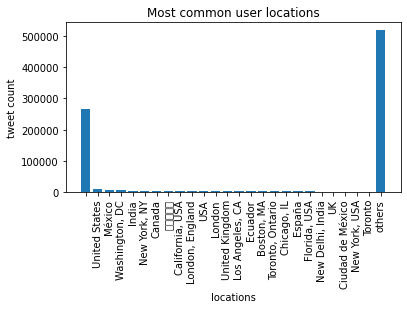

In [50]:
barplot(locations, counts, 'Most common user locations', 'locations', 'tweet count', 90)

The first thing we can see is that 30% of tweets don't contain any information, these users have left the field blank. Furthermore, the non-blank most repeated string is 'United States', but it is included in 'only' 1.1% of the tweets. 'Toronto', which is the top-25 most used location appears in only 0.2% of the tweets. Therefore, the distribution is quite flat over many many different strings (as can be seen in the right-most bar of the plot). Note also that different strings can refer to the same location entity: 'United States' and 'USA', for example.

Therefore, we can conclude that the field `user.location` contains valuable information (the top-25 list shows human-readable known locations), but there is much work to normalize them and obtain value from data.

## 4. Data Cleaning

Restricted users .....

Mirar si fer algo a lang (utilitzant langid)

Carmen

## 5. Analisys

**Count the total number of tweets on the database and the number of tweets with geolocation**

In [16]:
print("Total number of tweets:", tweets.count_documents({}))

Total number of tweets: 68822


In [26]:
count_with_geo = tweets.count_documents({'$or': [
                                                {'geo': {'$ne': None}}, 
                                                {'coordinates': {'$ne': None}},
                                                {'place': {'$ne': None}}
                                        ]},{})
print("Number of tweets with geolocation:", count_with_geo)

Number of tweets with geolocation: 931


**Top 25 vaccine related hashtags**

In [37]:
from bson.son import SON

pipeline = [
        {'$unwind': "$entities.hashtags" },
        {'$group': {'_id': '$entities.hashtags.text', 'count': {'$sum': 1}}},
        {"$sort": SON([("count", pymongo.DESCENDING)])},
        {'$limit': 25}
    ]

res = tweets.aggregate(pipeline)
for sample in res:
    print(sample)

{'_id': 'vaccine', 'count': 42747}
{'_id': 'COVID19', 'count': 15302}
{'_id': 'Vaccine', 'count': 9458}
{'_id': 'coronavirus', 'count': 3461}
{'_id': 'COVID', 'count': 3160}
{'_id': 'Covid', 'count': 3068}
{'_id': 'Pfizer', 'count': 2682}
{'_id': 'Covid19', 'count': 2489}
{'_id': 'CovidVaccine', 'count': 2459}
{'_id': 'patents', 'count': 1854}
{'_id': 'COVIDー19', 'count': 1818}
{'_id': 'covid19', 'count': 1412}
{'_id': 'AstraZeneca', 'count': 1315}
{'_id': 'vaccination', 'count': 1207}
{'_id': 'covid', 'count': 1167}
{'_id': 'UK', 'count': 1123}
{'_id': 'BillGates', 'count': 962}
{'_id': 'pandemic', 'count': 794}
{'_id': 'Vaccination', 'count': 789}
{'_id': 'cdc', 'count': 783}
{'_id': 'Moderna', 'count': 777}
{'_id': 'vaccines', 'count': 766}
{'_id': 'GatesFoundation', 'count': 736}
{'_id': 'UN', 'count': 721}
{'_id': 'GAVI', 'count': 718}


In [2]:
r = tweets.count_documents({})
print(r)

721077


In [4]:
have_place = tweets.count_documents({'place': {'$ne': None}})
have_geo = tweets.count_documents({'geo': {'$ne': None}})
have_coordinates = tweets.count_documents({'coordinates': {'$ne': None}})
print(have_place, 100*have_place/r)
print(have_geo, 100*have_geo/r)
print(have_coordinates, 100*have_coordinates/r)

4980 0.6906335939157676
108 0.014977596012631106
108 0.014977596012631106


In [5]:
have_user_loc = tweets.count_documents({'user.location': {'$ne': ''}})
print(have_user_loc, 100*have_user_loc/r)

504936 70.02525389105463


In [6]:
have_my_geo = tweets.count_documents({'my_geo': {'$ne': None}})
print(have_my_geo, 100*have_my_geo/r)

353979 49.0903190643995


In [13]:
pip = [
    {'$group': {'_id': '$lang', 'count': {'$sum': 1}}},
    {'$sort': SON([('count', pymongo.DESCENDING)])},
    {'$limit': 10}
]
languages = tweets.aggregate(pip)
for lang in languages:
    print(lang)

{'_id': 'en', 'count': 531462}
{'_id': 'es', 'count': 106193}
{'_id': 'fr', 'count': 57837}
{'_id': 'und', 'count': 7199}
{'_id': 'hi', 'count': 3637}
{'_id': 'nl', 'count': 2285}
{'_id': 'ca', 'count': 1801}
{'_id': 'in', 'count': 1378}
{'_id': 'tl', 'count': 1190}
{'_id': 'pt', 'count': 963}


In [14]:
pip = [
    {'$match': {'my_geo': {'$ne': None}}},
    {'$group': {'_id': '$my_geo.country', 'count': {'$sum': 1}}},
    {'$sort': SON([('count', pymongo.DESCENDING)])},
    {'$limit': 10}
]
countries = tweets.aggregate(pip)
for country in countries:
    print(country)

{'_id': 'United States', 'count': 177805}
{'_id': 'United Kingdom', 'count': 32726}
{'_id': 'Canada', 'count': 24412}
{'_id': 'India', 'count': 17992}
{'_id': 'France', 'count': 16476}
{'_id': 'Mexico', 'count': 8866}
{'_id': 'Spain', 'count': 7249}
{'_id': 'Ecuador', 'count': 5053}
{'_id': 'Australia', 'count': 3793}
{'_id': 'Germany', 'count': 3237}
